In [1]:
#| hide

# This is to render Plotly plots into HTML
# For more information, see https://quarto.org/docs/interactive/widgets/jupyter.html#plotly
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('mlforecast').setLevel(logging.ERROR)

# Electricity Load Forecast

> In this example we will show how to perform electricity load forecasting considering a model capable of handling multiple seasonalities (MSTL).

## Introduction

Some time series are generated from very low frequency data. These data generally exhibit multiple seasonalities. For example, hourly data may exhibit repeated patterns every hour (every 24 observations) or every day (every 24 * 7, hours per day, observations). This is the case for electricity load. Electricity load may vary hourly, e.g., during the evenings electricity consumption may be expected to increase. But also, the electricity load varies by week. Perhaps on weekends there is an increase in electrical activity.


In this example we will show how to model the two seasonalities of the time series to generate accurate forecasts in a short time. We will use hourly PJM electricity load data. The original data can be found [here](https://github.com/jnagura/Energy-consumption-prediction-analysis). 

## Libraries

In this example we will use the following libraries:


- [`MLForecast`](https://nixtla.github.io/mlforecast/). Accurate and ⚡️ fast forecasting withclassical machine learning models. 
- [`DatasetsForecast`](https://github.com/Nixtla/datasetsforecast). Used to evaluate the performance of the forecasts.
- [`Prophet`](https://github.com/facebook/prophet). Benchmark model developed by Facebook.
- [`NeuralProphet`](https://github.com/ourownstory/neural_prophet). Deep Learning version of `Prophet`. Used as benchark.

In [2]:
%%capture
!pip install datasetsforecast
!pip install prophet
!pip install mlforecast
!pip install -U utilsforecast

## Forecast using Multiple Seasonalities

### Electricity Load Data

According to the [dataset's page](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption),

> PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW).

Let's take a look to the data.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=10)

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv')
df.columns = ['ds', 'y']
df.insert(0, 'unique_id', 'PJM_Load_hourly')
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
print(f'Shape of the data {df.shape}')
df.tail()

Shape of the data (32896, 3)


,unique_id,ds,y
32891,PJM_Load_hourly,2001-12-31 20:00:00,36392.0
32892,PJM_Load_hourly,2001-12-31 21:00:00,35082.0
32893,PJM_Load_hourly,2001-12-31 22:00:00,33890.0
32894,PJM_Load_hourly,2001-12-31 23:00:00,32590.0
32895,PJM_Load_hourly,2002-01-01 00:00:00,31569.0


<AxesSubplot: xlabel='ds'>

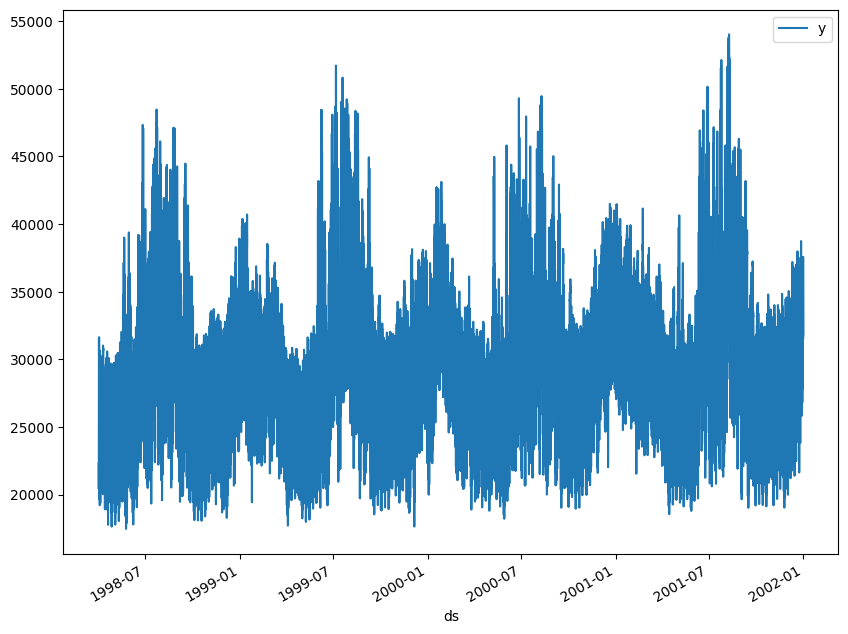

In [5]:
df.plot(x='ds', y='y')

We clearly observe that the time series exhibits seasonal patterns. Moreover, the time series contains `32,896` observations, so it is necessary to use very computationally efficient methods to display them in production.

### Analizing Seasonalities

First we must visualize the seasonalities of the model. As mentioned before, the electricity load presents seasonalities every 24 hours (Hourly) and every 24 * 7 (Daily) hours. Therefore, we will use `[24, 24 * 7]` as the seasonalities for the model. In order to analize how they affect our series we are going to use the `Difference` method.

In [6]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

We can use the `MLForecast.preprocess` method to explore different transformations. It looks like these series have a strong seasonality on the hour of the day, so we can subtract the value from the same hour in the previous day to remove it. This can be done with the mlforecast.`target_transforms.Differences` transformer, which we pass through `target_transforms`.  
  

In order to analize the trends individually and combined we are going to plot them individually and combined. Therefore, we can compare them against the original series. We can use the next function for that.

In [7]:
def plot_differences(df, differences,fname):
    prep = [df]
    # Plot individual Differences
    for d in differences:
        fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq='H',  # our series have hourly frequency 
        target_transforms=[Differences([d])],
        )
        df_ = fcst.preprocess(df)
        df_['unique_id'] = df_['unique_id'] + f'_{d}'
        prep.append(df_)
        
    # Plot combined Differences
    fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)
    prep = pd.concat(prep, ignore_index=True)
    #return prep
    n_series = len(prep['unique_id'].unique())
    fig, ax = plt.subplots(nrows=n_series, figsize=(7 * n_series, 10*n_series), squeeze=False)
    for title, axi in zip(prep['unique_id'].unique(), ax.flat):
        df_ = prep[prep['unique_id'] == title]
        df_.set_index('ds')['y'].plot(title=title, ax=axi)
    fig.savefig(fname, bbox_inches='tight')
    plt.show()
    plt.close()

Since the seasonalities are present at `24` hours (daily) and `24*7` (weekly) we are going to substract them from the serie using `Differences([24, 24*7])` and plot them.

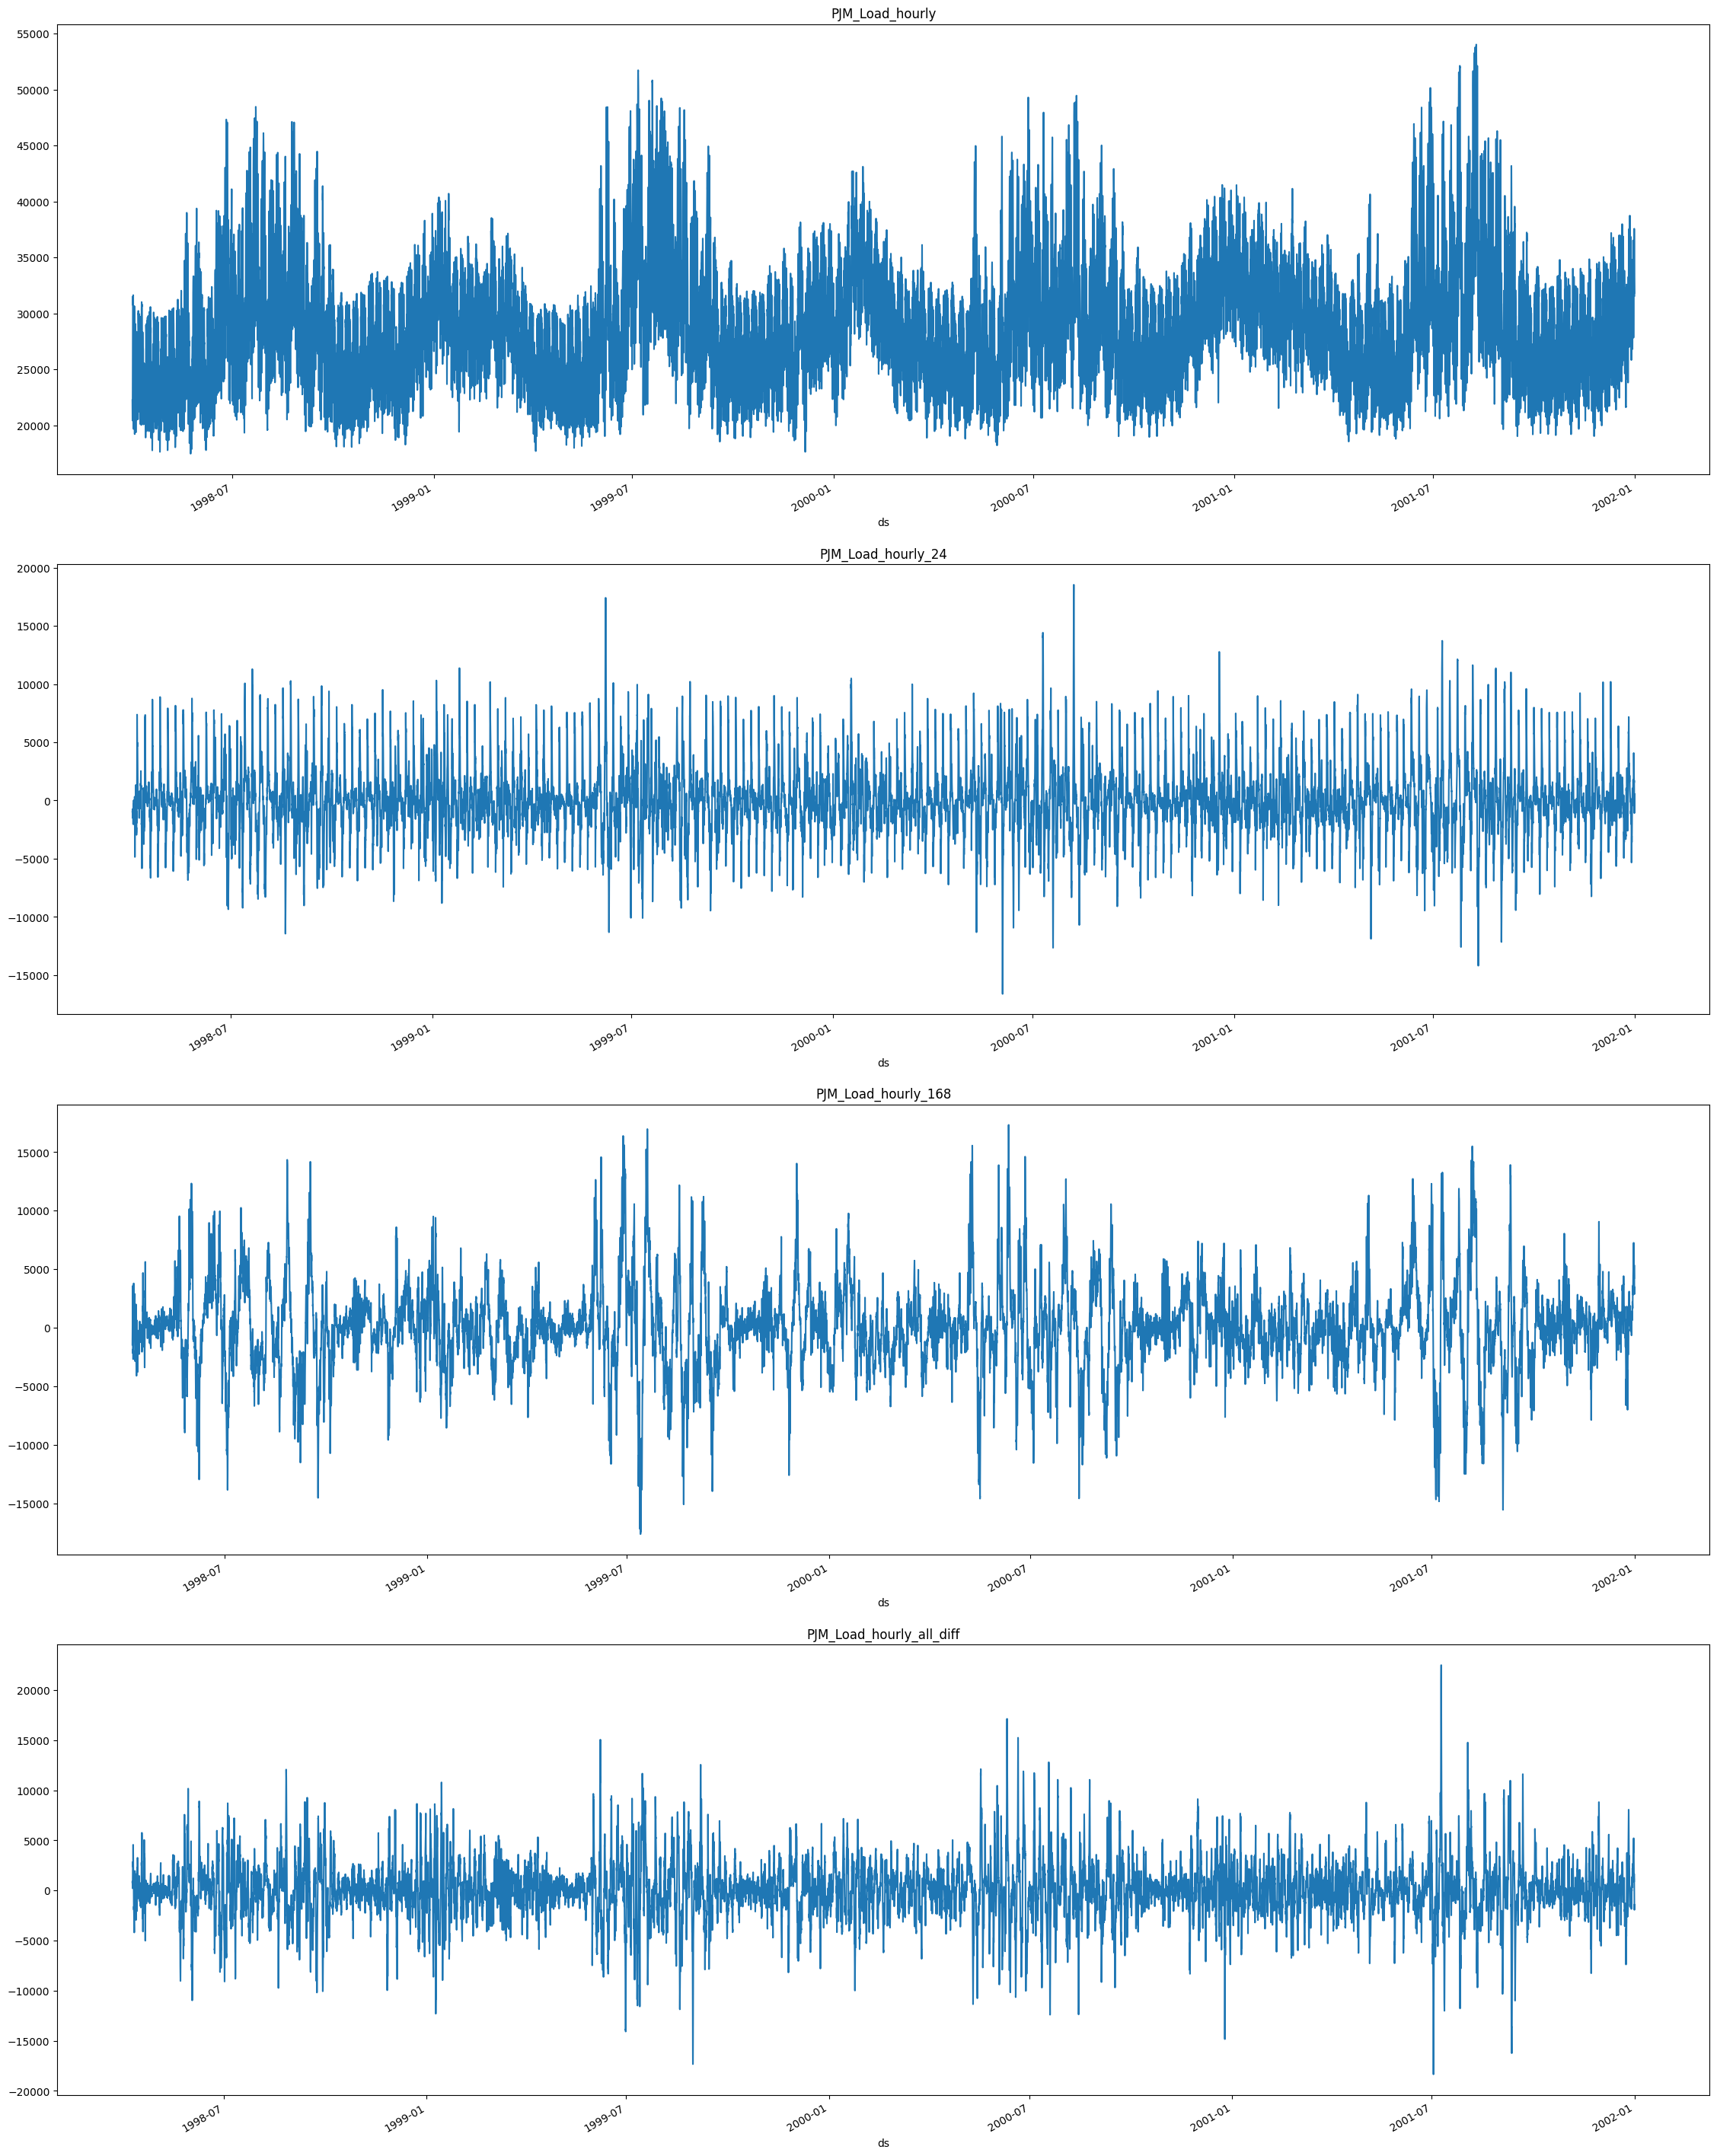

In [8]:
plot_differences(df=df, differences=[24, 24*7], fname='../figs/load_forecasting__differences.png')

As we can see when we extract the 24 difference (daily) in `PJM_Load_hourly_24` the series seem to stabilize sisnce the peaks seem more uniform in comparison with the original series `PJM_Load_hourly`.

When we extrac the 24*7 (weekly) `PJM_Load_hourly_168` difference we can see there is more periodicity in the peaks in comparison with the original series.    

Finally we can see the result from the combined result from substracting all the differences `PJM_Load_hourly_all_diff`.

For modeling we are going to use both difference for the forecasting, therefore we are setting the argument `target_transforms` from the `MLForecast` object equal to `[Differences([24, 24*7])]`, if we wanted to include a yearly difference we would need to add the term `24*365`.

In [9]:
fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
)
prep = fcst.preprocess(df)
prep

,unique_id,ds,y
192,PJM_Load_hourly,1998-04-09 02:00:00,831.0
193,PJM_Load_hourly,1998-04-09 03:00:00,918.0
194,PJM_Load_hourly,1998-04-09 04:00:00,760.0
195,PJM_Load_hourly,1998-04-09 05:00:00,849.0
196,PJM_Load_hourly,1998-04-09 06:00:00,710.0
...,...,...,...
32891,PJM_Load_hourly,2001-12-31 20:00:00,684.0
32892,PJM_Load_hourly,2001-12-31 21:00:00,-384.0
32893,PJM_Load_hourly,2001-12-31 22:00:00,-1250.0
32894,PJM_Load_hourly,2001-12-31 23:00:00,-1935.0


<AxesSubplot: xlabel='ds'>

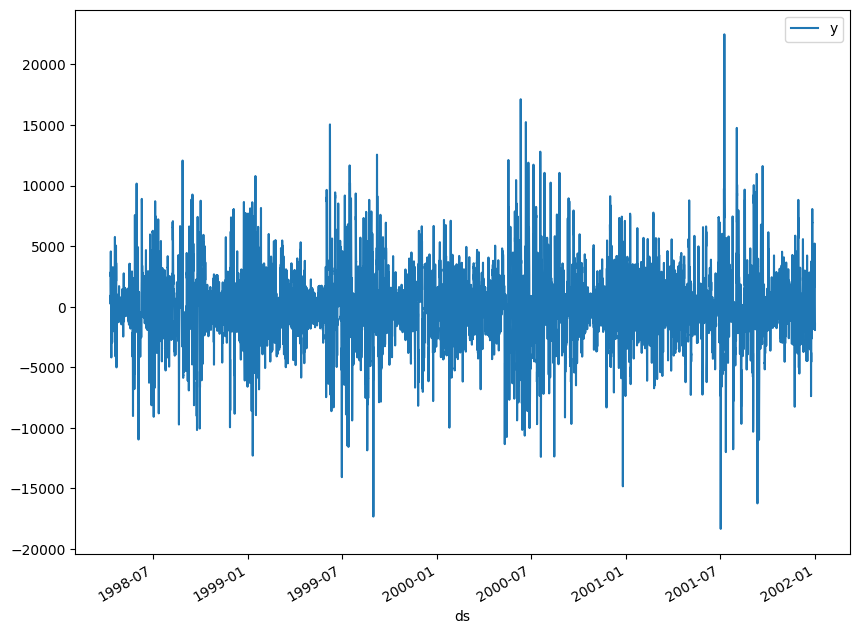

In [10]:
prep.plot(x='ds', y='y')

### Model Selection with Cross-Validation

In [11]:
from sklearn.base import BaseEstimator

class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

In [12]:
import lightgbm as lgb
from mlforecast.target_transforms import Differences
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

lgb_params = {
    'verbosity': -1,
    'num_leaves': 720,
}
models ={
        'naive': Naive(),
        'avg': lgb.LGBMRegressor(),
        'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    }

mlf = MLForecast(
    models = models, 
    freq='H',  # our series have hourly frequency 
    target_transforms=[Differences([24, 24*7])],
    lags=range(1,25,1),
    # lag_transforms={  
    #     1: [expanding_mean],
    #     24: [(rolling_mean, 48)],
    # }
)

crossvalidation_df = mlf.cross_validation(
    data=df,
    window_size=24,
    n_windows=3,
)
crossvalidation_df

,unique_id,ds,cutoff,y,naive,avg,q75,q25
0,PJM_Load_hourly,2001-12-29 01:00:00,2001-12-29,27925.0,28004.0,28023.863331,28225.948078,27987.670696
1,PJM_Load_hourly,2001-12-29 02:00:00,2001-12-29,26721.0,27001.0,27035.179931,27487.482816,26992.489878
2,PJM_Load_hourly,2001-12-29 03:00:00,2001-12-29,26111.0,26924.0,26947.953524,27623.890191,26783.092082
3,PJM_Load_hourly,2001-12-29 04:00:00,2001-12-29,25832.0,27126.0,27154.689565,28068.894527,26866.429763
4,PJM_Load_hourly,2001-12-29 05:00:00,2001-12-29,25867.0,27196.0,27223.052423,28220.021034,26790.094191
...,...,...,...,...,...,...,...,...
19,PJM_Load_hourly,2001-12-31 20:00:00,2001-12-31,36392.0,39943.0,37346.450238,38656.782647,33264.258449
20,PJM_Load_hourly,2001-12-31 21:00:00,2001-12-31,35082.0,39701.0,36957.636361,38080.674095,32627.572931
21,PJM_Load_hourly,2001-12-31 22:00:00,2001-12-31,33890.0,39375.0,36419.200766,37536.386879,31914.154140
22,PJM_Load_hourly,2001-12-31 23:00:00,2001-12-31,32590.0,38760.0,35616.910763,37020.214803,30881.154909


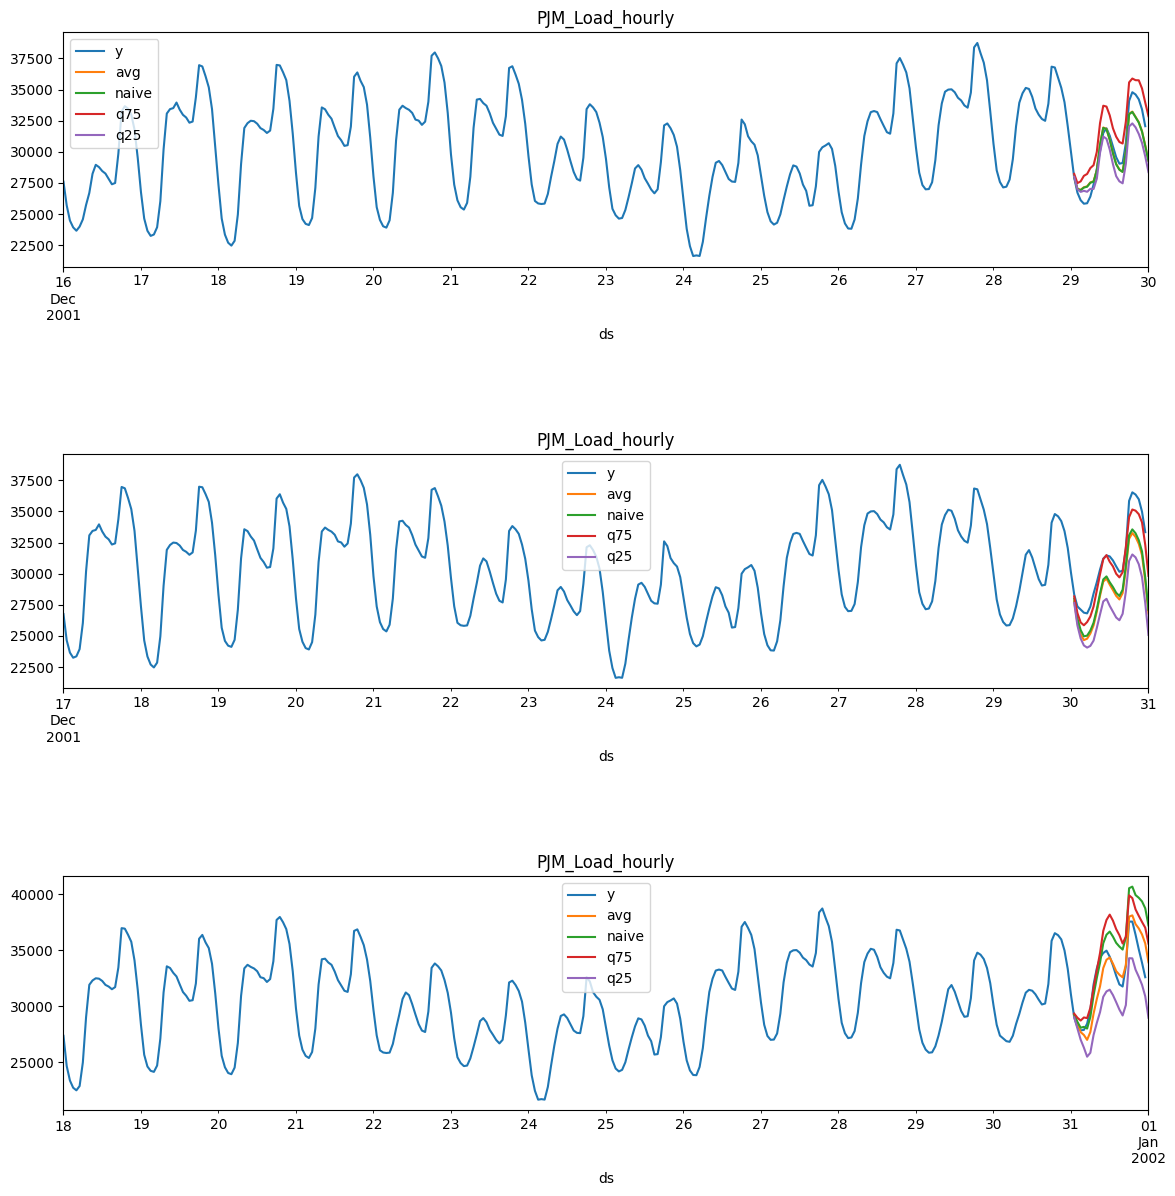

In [13]:
def plot_cv(df, df_cv, uid, fname, last_n=24 * 14):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 14), gridspec_kw=dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        max_date = df_cv.query('unique_id == @uid & cutoff == @cutoff')['ds'].max()
        df[df['ds'] < max_date].query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y='avg')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y='naive')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y='q75')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y='q25')
        
        
    fig.savefig(fname, bbox_inches='tight')
    plt.show()
    plt.close()
    
plot_cv(df, crossvalidation_df, 'PJM_Load_hourly', '../figs/load_forecasting__predictions.png')

In [17]:
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

In [30]:
models = ['naive', 'q25','avg', 'q75']
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape
    ]

In [16]:
crossvalidation_df.head()

,unique_id,ds,cutoff,y,naive,avg,q75,q25
0,PJM_Load_hourly,2001-12-29 01:00:00,2001-12-29,27925.0,28004.0,28023.863331,28225.948078,27987.670696
1,PJM_Load_hourly,2001-12-29 02:00:00,2001-12-29,26721.0,27001.0,27035.179931,27487.482816,26992.489878
2,PJM_Load_hourly,2001-12-29 03:00:00,2001-12-29,26111.0,26924.0,26947.953524,27623.890191,26783.092082
3,PJM_Load_hourly,2001-12-29 04:00:00,2001-12-29,25832.0,27126.0,27154.689565,28068.894527,26866.429763
4,PJM_Load_hourly,2001-12-29 05:00:00,2001-12-29,25867.0,27196.0,27223.052423,28220.021034,26790.094191


In [32]:
def evaluate_crossvalidation(crossvalidation_df, metrics, models):
    evaluations = []
    for c in crossvalidation_df['cutoff'].unique():
        df_cv = crossvalidation_df.query('cutoff == @c')
        evaluation = evaluate(
            df = df_cv,
            metrics=metrics,
            models=models
            )
        evaluations.append(evaluation)
    evaluations = pd.concat(evaluations, ignore_index=True).drop(columns='unique_id')
    evaluations = evaluations.groupby('metric').mean()#.agg(['mean', 'std'])
    return evaluations

evaluate_crossvalidation(crossvalidation_df, metrics, models)
    

,naive,q25,avg,q75
metric,,,,
mae,1.777736e+03,2.618315e+03,1.493002e+03,1.540420e+03
mape,5.528630e-02,8.186507e-02,4.735628e-02,4.880128e-02
mse,5.048878e+06,9.173373e+06,3.364051e+06,3.697348e+06
rmse,2.097967e+03,2.859729e+03,1.713634e+03,1.760189e+03
smape,2.755334e-02,4.323457e-02,2.429876e-02,2.364492e-02


We can se that the model `avg` has top performance in most metrics. We can use it for prediction.

#### Produce forecasts

To generate forecasts we only have to use the `predict` method specifying the forecast horizon (`h`). In addition, to calculate prediction intervals associated to the forecasts, we can include the parameter `level` that receives a list of levels of the prediction intervals we want to build. In this case we will only calculate the 90% forecast interval (`level=[90]`). 

In [17]:
forecasts = sf.predict(h=24, level=[90])
forecasts.head()

,ds,MSTL,MSTL-lo-90,MSTL-hi-90
unique_id,,,,
PJM_Load_hourly,2002-01-01 01:00:00,29956.744141,29585.187500,30328.298828
PJM_Load_hourly,2002-01-01 02:00:00,29057.691406,28407.498047,29707.884766
PJM_Load_hourly,2002-01-01 03:00:00,28654.699219,27767.101562,29542.298828
PJM_Load_hourly,2002-01-01 04:00:00,28499.009766,27407.640625,29590.378906
PJM_Load_hourly,2002-01-01 05:00:00,28821.716797,27552.236328,30091.197266


Let's look at our forecasts graphically.

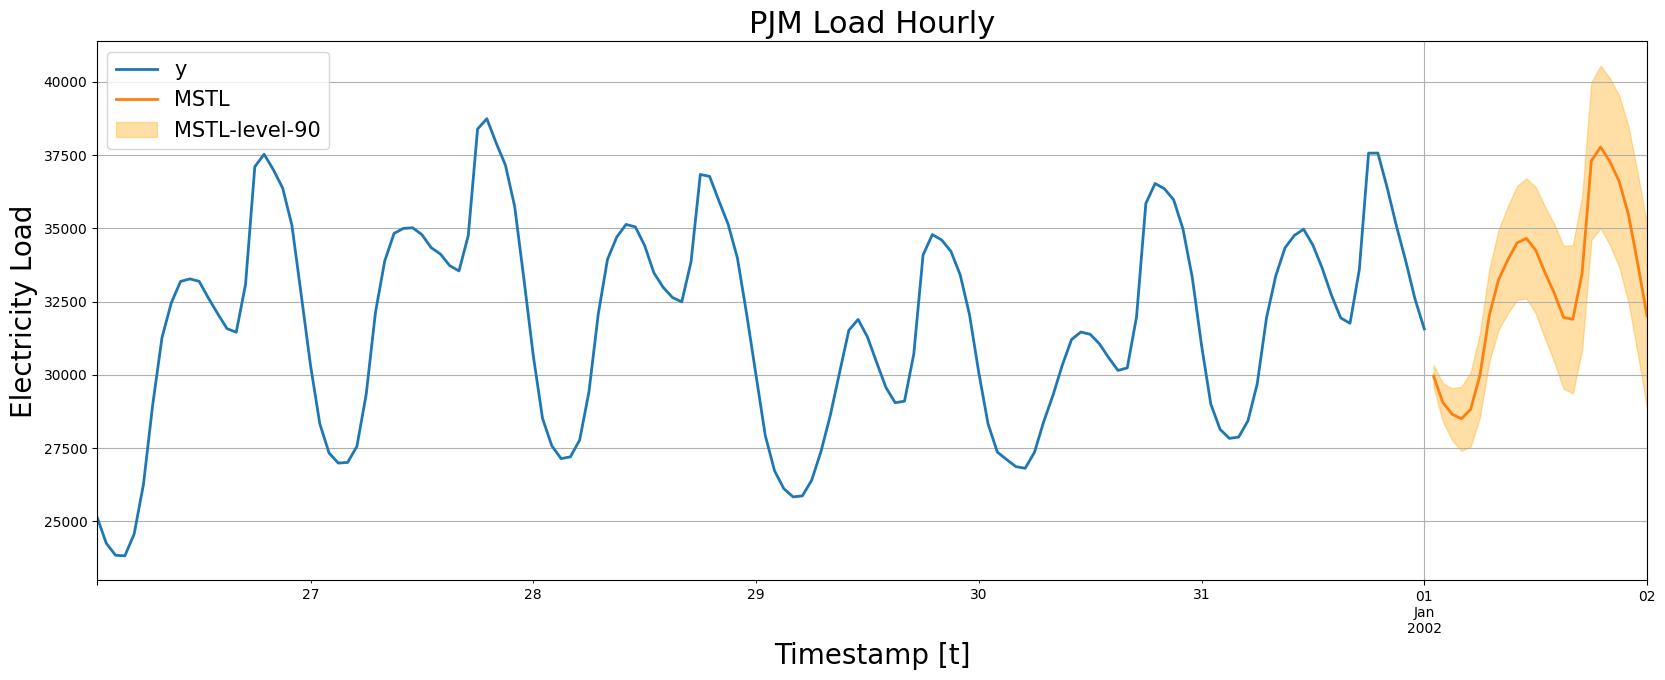

In [18]:
_, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([df, forecasts]).set_index('ds').tail(24 * 7)
df_plot[['y', 'MSTL']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['MSTL-lo-90'], 
                df_plot['MSTL-hi-90'],
                alpha=.35,
                color='orange',
                label='MSTL-level-90')
ax.set_title('PJM Load Hourly', fontsize=22)
ax.set_ylabel('Electricity Load', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In the next section we will plot different models so it is convenient to reuse the previous code with the following function. 

In [19]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(24 * 7)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
    colors = ['orange', 'green', 'red']
    for model, color in zip(models, colors):
        ax.fill_between(df_plot.index, 
                        df_plot[f'{model}-lo-90'], 
                        df_plot[f'{model}-hi-90'],
                        alpha=.35,
                        color=color,
                        label=f'{model}-level-90')
    ax.set_title('PJM Load Hourly', fontsize=22)
    ax.set_ylabel('Electricity Load', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

### Performance of the MSTL model

#### Split Train/Test sets

To validate the accuracy of the `MSTL` model, we will show its performance on unseen data. We will use a classical time series technique that consists of dividing the data into a training set and a test set. We will leave the last 24 observations (the last day) as the test set. So the model will train on `32,872` observations. 

In [20]:
df_test = df.tail(24)
df_train = df.drop(df_test.index)

#### MSTL model

In addition to the `MSTL` model, we will include the `SeasonalNaive` model as a benchmark to validate the added value of the `MSTL` model. Including `StatsForecast` models is as simple as adding them to the list of models to be fitted.

In [21]:
sf = StatsForecast(
    models=[mstl, SeasonalNaive(season_length=24)], # add SeasonalNaive model to the list
    freq='H'
)

To measure the fitting time we will use the `time` module. 

In [22]:
from time import time

To retrieve the forecasts of the test set we only have to do fit and predict as before.

In [23]:
init = time()
sf = sf.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test), level=[90])
end = time()
forecasts_test.head()

,ds,MSTL,MSTL-lo-90,MSTL-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,
PJM_Load_hourly,2001-12-31 01:00:00,28345.212891,27973.572266,28716.853516,28326.0,23468.693359,33183.308594
PJM_Load_hourly,2001-12-31 02:00:00,27567.455078,26917.085938,28217.824219,27362.0,22504.693359,32219.306641
PJM_Load_hourly,2001-12-31 03:00:00,27260.001953,26372.138672,28147.865234,27108.0,22250.693359,31965.306641
PJM_Load_hourly,2001-12-31 04:00:00,27328.125000,26236.410156,28419.839844,26865.0,22007.693359,31722.306641
PJM_Load_hourly,2001-12-31 05:00:00,27640.673828,26370.773438,28910.572266,26808.0,21950.693359,31665.306641


In [24]:
time_mstl = (end - init) / 60
print(f'MSTL Time: {time_mstl:.2f} minutes')

MSTL Time: 0.13 minutes


Then we were able to generate forecasts for the next 24 hours. Now let's look at the graphical comparison of the forecasts with the actual values.

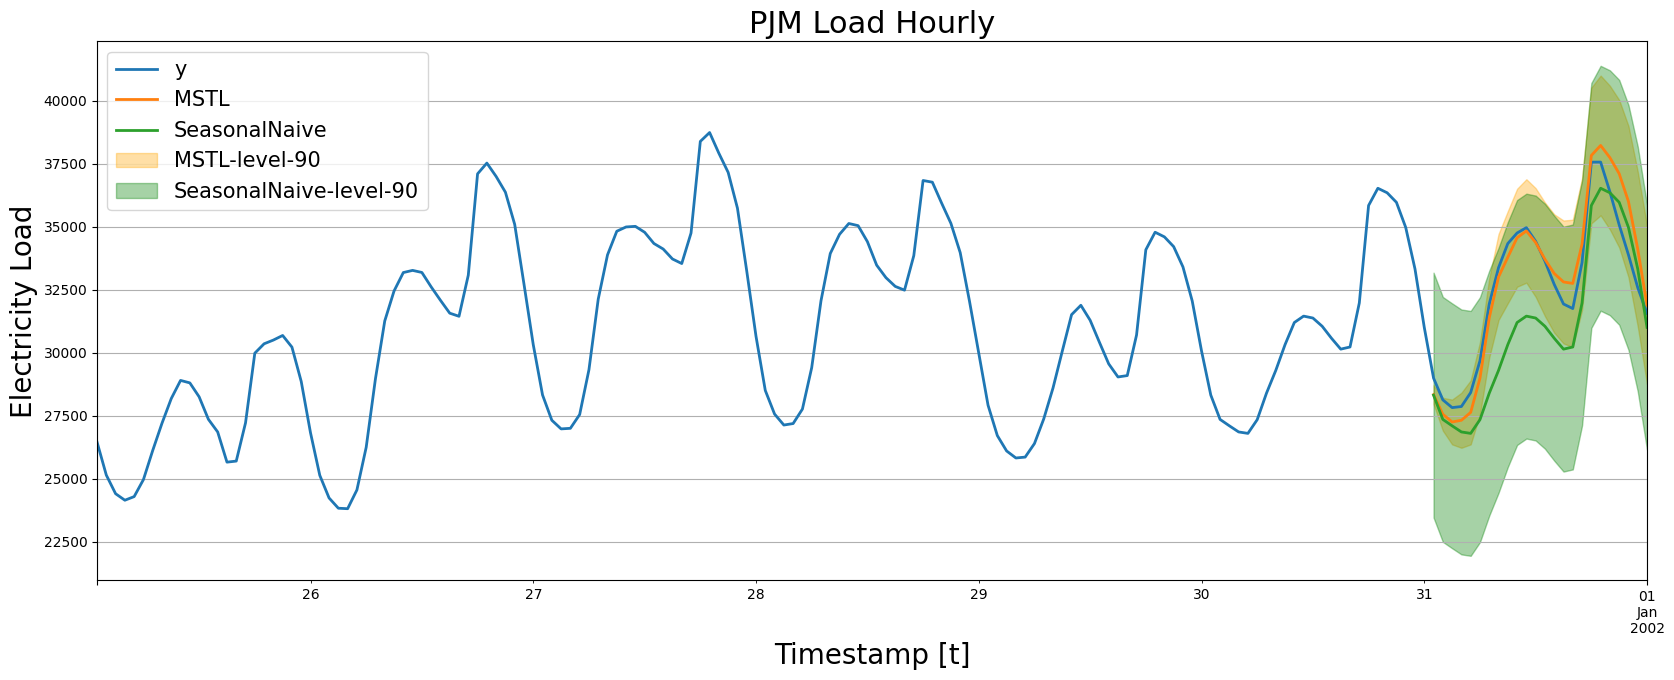

In [25]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL', 'SeasonalNaive'])

Let's look at those produced only by `MSTL`. 

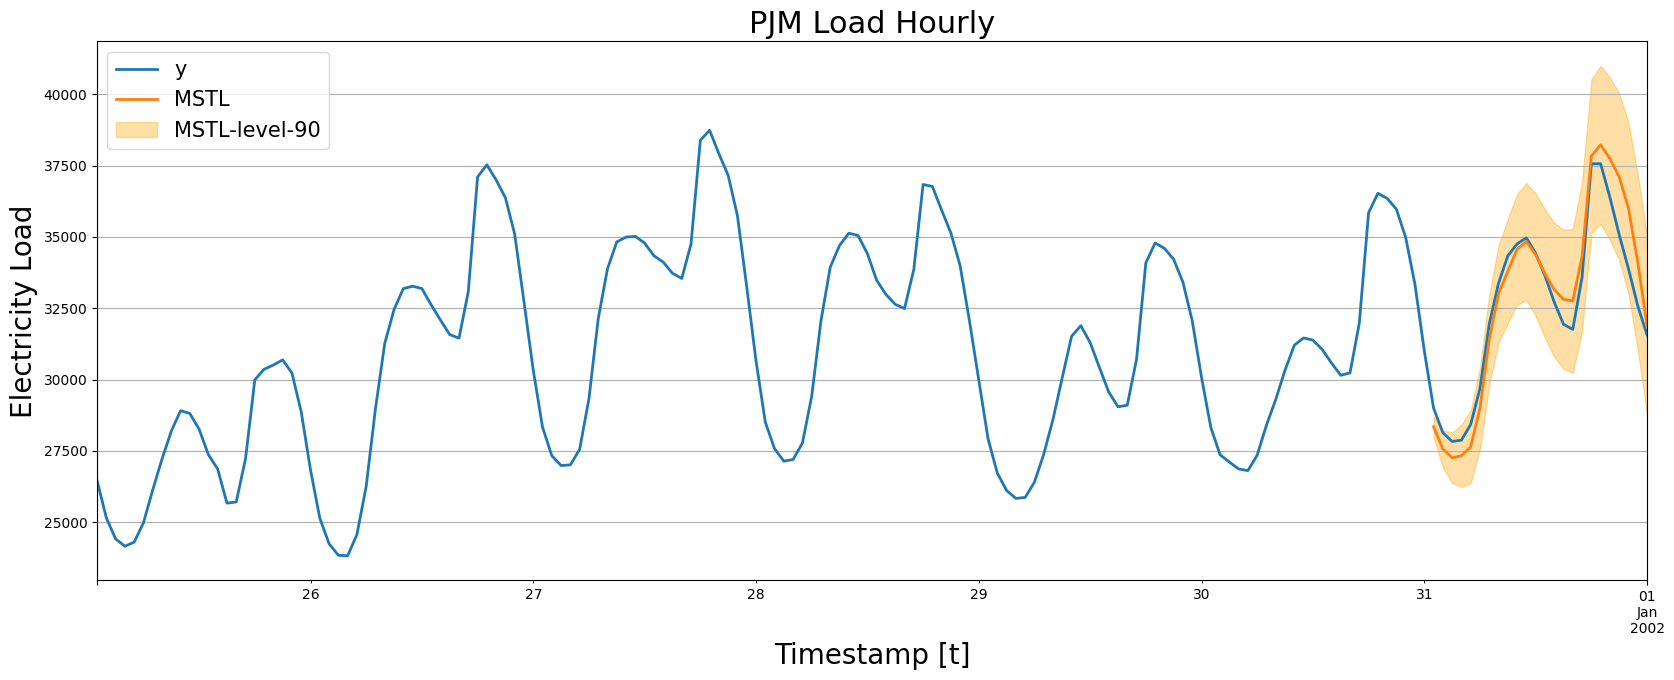

In [26]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL'])

We note that `MSTL` produces very accurate forecasts that follow the behavior of the time series. Now let us calculate numerically the accuracy of the model. We will use the following metrics: `MAE`, `MAPE`, `MASE`, `RMSE`, `SMAPE`.

In [27]:
from datasetsforecast.losses import (
    mae, mape, mase, rmse, smape
)

In [28]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                 y_true[model].values, 
                                                 y_hist['y'].values, seasonality=24)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [29]:
evaluate_performace(df_train, df_test, forecasts_test, models=['MSTL', 'SeasonalNaive'])

,mase,mae,mape,rmse,smape
MSTL,0.341926,709.932048,2.182804,892.888012,2.162832
SeasonalNaive,0.894653,1857.541667,5.648190,2201.384101,5.868604
